In [1]:
%load_ext Cython

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

from tqdm import tqdm
from scipy.special import erfc
import boost_histogram as bh

from lmfit.models import *
from lmfit import Model
import json

import inspect

In [3]:
with open('chargeTree.json') as f:
    data = json.load(f)
# golden_df['ratio'] = golden_df['num_of_events'] / golden_df['total_q']
# golden_df['run'] = golden_df.run_num*10 + golden_df.file_num
# golden_df = golden_df.sort_values(by=['run_num', 'file_num']).reset_index()
# golden_df['sum_q'] = np.cumsum(golden_df['total_q'])
frames = []
for run_num, run_data in data.items():
    total_q = 0
    for num, x_data in run_data.items():
        elec = x_data['nElec'].values()
        total_q += x_data['fcChargeMin']-x_data['fcChargeMax']
    
    frames.append({'run_num' : run_num, 'file_num': num, 'total_q' : total_q, 'nElec': sum(elec)})
        
golden_df = pd.DataFrame(frames)
golden_df['ratio'] = golden_df['nElec'] / golden_df['total_q']
golden_df.head()

,run_num,file_num,total_q,nElec,ratio
0,5032,110,-34307.587223,1130,-0.032937
1,5036,545,-169221.993512,1881,-0.011116
2,5038,1235,-380565.939434,20727,-0.054464
3,5039,320,-98526.892316,14208,-0.144204
4,5040,475,-147342.677633,26301,-0.178502


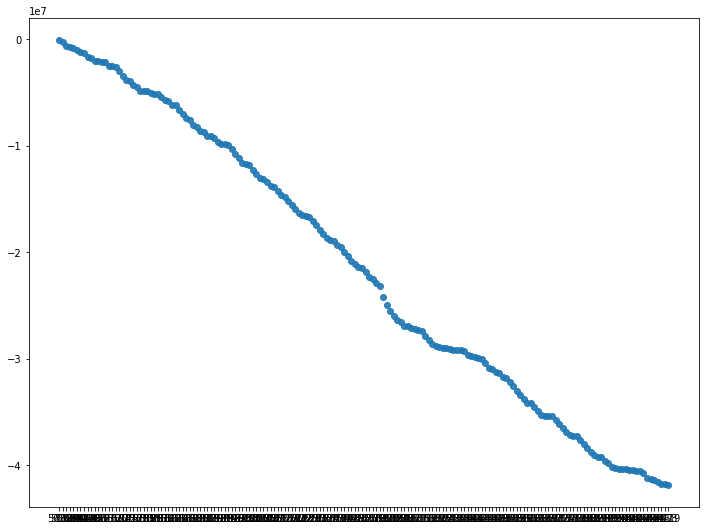

In [4]:
fig = plt.figure(num=None, figsize=(12,9), facecolor='w', edgecolor='k')
plt.scatter(golden_df['run_num'], np.cumsum(golden_df['total_q']), alpha=0.9);

Parameters([('amplitude', <Parameter 'amplitude', value=13.738621294223822 +/- 0.221, bounds=[-inf:inf]>), ('center', <Parameter 'center', value=-0.11885383326074353 +/- 0.00331, bounds=[-inf:inf]>), ('sigma', <Parameter 'sigma', value=0.041117153252385075 +/- 0.00214, bounds=[0.0:inf]>), ('fwhm', <Parameter 'fwhm', value=0.09682349482178143 +/- 0.00504, bounds=[-inf:inf], expr='2.3548200*sigma'>), ('height', <Parameter 'height', value=133.30001579398493 +/- 6.45, bounds=[-inf:inf], expr='0.3989423*amplitude/max(2.220446049250313e-16, sigma)'>)])


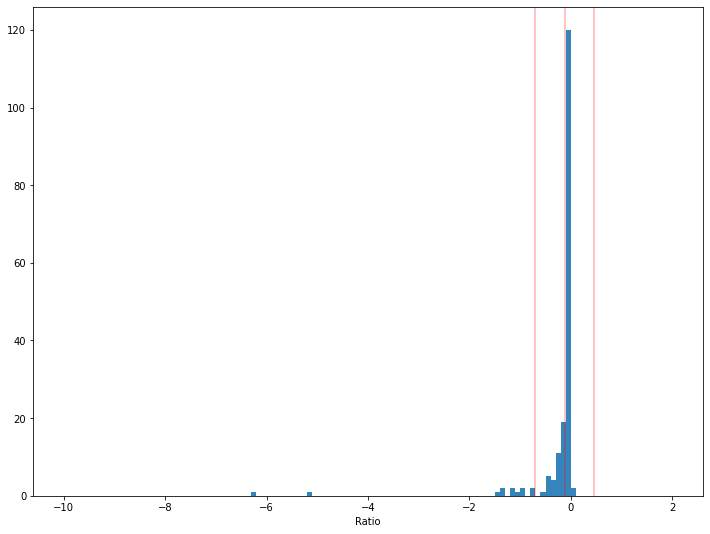

In [12]:
SIGMA = 6
fig = plt.figure(num=None, figsize=(12,9), facecolor='w', edgecolor='k')
bin_heights, bin_borders, _ = plt.hist(golden_df['ratio'], bins=120, histtype='stepfilled', alpha=0.9, range=[-10, 2])

x = bin_borders[:-1]
y = bin_heights

mod = GaussianModel()
pars = mod.guess(y, x=x)
#pars['center'].set(value=70000, min=50000, max=1000000)
out = mod.fit(y, pars, x=x)

#xs=np.linspace(6000, 100000, 100000)

#plt.plot(xs, out.eval(x=xs), 'r-', label='best fit')

center = out.params['center'].value
fwhm = out.params['fwhm'].value

print(out.params)

plt.axvline(x=center, c='r', alpha=0.3)
plt.axvline(x=center+SIGMA*fwhm, c='r', alpha=0.3)
plt.axvline(x=center-SIGMA*fwhm, c='r', alpha=0.3)

#plt.ylim([0, out.params['height']*1.5])
plt.xlabel('Ratio')
plt.show()

-0.11885383326074353


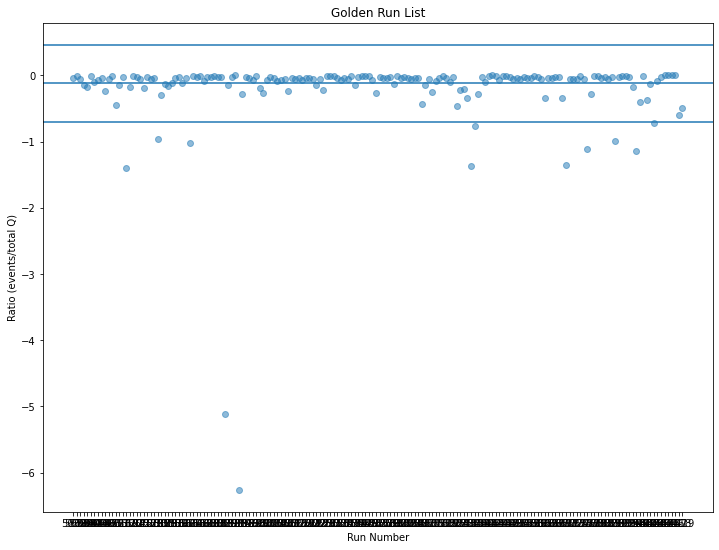

In [13]:
fig = plt.figure(num=None, figsize=(12,9), facecolor='w', edgecolor='k')
plt.scatter(golden_df['run_num'], golden_df['ratio'], alpha=0.5)
print(center)
plt.axhline(y=center)
plt.axhline(y=center+SIGMA*fwhm)
plt.axhline(y=center-SIGMA*fwhm)
plt.xlabel('Run Number')
plt.title('Golden Run List')
plt.ylabel('Ratio (events/total Q)')
#plt.ylim([0, 200_000])
plt.show()


In [14]:
after_cut = golden_df[ (golden_df['ratio'] >= center-SIGMA*fwhm) & (golden_df['ratio'] <= center+SIGMA*fwhm)]
after_cut.head()
print(len(after_cut))

162


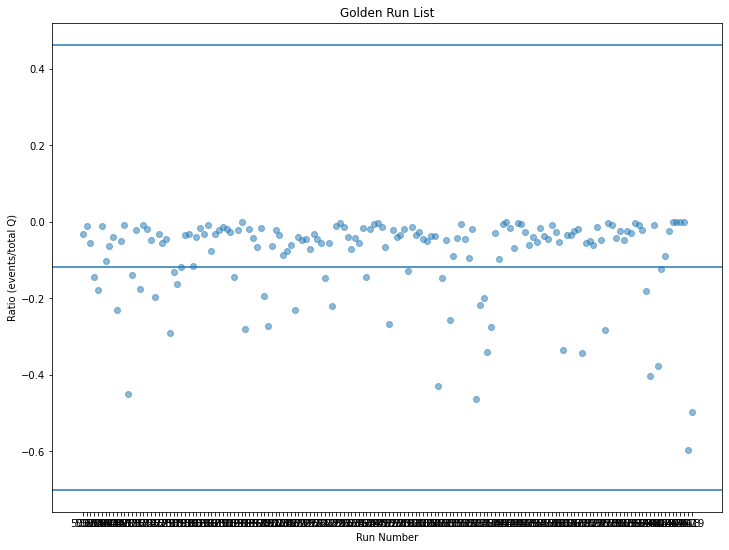

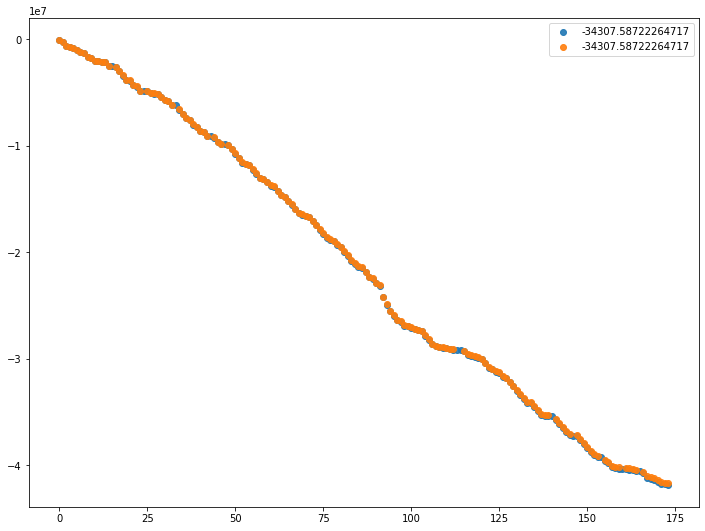

-34307.58722264717


In [15]:
fig = plt.figure(num=None, figsize=(12,9), facecolor='w', edgecolor='k')
plt.scatter(after_cut['run_num'], after_cut['ratio'], alpha=0.5)
plt.axhline(y=center)
plt.axhline(y=center+SIGMA*fwhm)
plt.axhline(y=center-SIGMA*fwhm)
plt.xlabel('Run Number')
plt.title('Golden Run List')
plt.ylabel('Ratio (events/total Q)')
#plt.ylim([0, 50000])
plt.show()


fig = plt.figure(num=None, figsize=(12,9), facecolor='w', edgecolor='k')
plt.scatter(golden_df.index, np.cumsum(golden_df['total_q']), alpha=0.9, label=f'{np.max(np.cumsum(golden_df.total_q))}')
plt.scatter(after_cut.index, np.cumsum(after_cut['total_q']), alpha=0.9, label=f'{np.max(np.cumsum(after_cut.total_q))}')
plt.legend()

plt.show()


print(Q_tot := np.max(np.cumsum(after_cut.total_q)))

In [9]:
def luminosity(Q_tot=2822.038E-6):
    Q_tot *= 1E-6
    # Q_tot = 15623.89E-6  # mCE-6 -> C
    # Q_tot = 2822.038E-6  # mCE-6 -> C
    l = 5  # cm
    rho = 0.0708  # g/cm3
    Avigadro = 6.022E23  # mol^−1
    qe = 1.602E-19  # C
    MH = 1.007  # g/mol
    conv_cm2_to_fm2 = 1E-39 # From wolfram alpha
    conv_cm2_to_mubarn = 1E-30

    return (Q_tot*l*rho*Avigadro)/(qe*MH) * conv_cm2_to_mubarn

In [10]:
print(f'{Q_tot:0.10f}')
print(f'{luminosity(Q_tot=Q_tot):0.2e}')

nan
nan


In [11]:
from shutil import copyfile
for run,fil in zip(after_cut.run_num, after_cut.file_num):
    src = f'/Volumes/LaCiE/physics/e1d/v2/H2_full/h10_r{run}_{fil:02d}.root'
    dst = f'/Users/tylern/Data/e1d/golden_run/h10_r{run}_{fil:02d}.root'
    # copyfile(src, dst)
    
    print(f"r{run}_{fil:02d}.B00")
    